In [17]:
import pathlib

import pandas as pd
from jinja2 import Environment, FileSystemLoader
from weasyprint import HTML
import matplotlib.pyplot as plt

from utils import *
from WeatherDataAggregator import WeatherDataAggregator

# Duomenų surinkimas

In [2]:
fetcher = WeatherDataAggregator('kauno-ams', 'https://api.meteo.lt')
fetcher._fetch_metadata()
df_obs = fetcher.fetch_last_days(50)
df_fcast = fetcher.fetch_forecast(code='kaunas')

Duomenys siunčiami iš api.meteo.lt


Parsiųstos dienos: 100%|████████████████████████| 50/50 [01:01<00:00,  1.23s/it]


# Duomenų paruošimas

Patikriname surinktų duomenų tipus, įsitikiname, kad netrūksta būtinų parametrų, ir pagal poreikį konvertuojame laiko žymas į reikiamą laiko juostą.

In [3]:
df_obs.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1177 entries, 2025-10-06 00:00:00+00:00 to 2025-08-18 23:00:00+00:00
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   temperature       1177 non-null   float64
 1   precipitation     1177 non-null   float64
 2   relativeHumidity  1177 non-null   int64  
dtypes: float64(2), int64(1)
memory usage: 36.8 KB


In [4]:
df_fcast.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 85 entries, 2025-10-05 23:00:00+00:00 to 2025-10-12 18:00:00+00:00
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   temperature       85 non-null     float64
 1   precipitation     85 non-null     float64
 2   relativeHumidity  85 non-null     int64  
dtypes: float64(2), int64(1)
memory usage: 2.7 KB


In [5]:
df_fcast.index = df_fcast.index.tz_convert("Europe/Vilnius")
df_fcast.index = df_fcast.index.tz_localize(None)

df_obs.index = df_obs.index.tz_convert("Europe/Vilnius")
df_obs.index = df_obs.index.tz_localize(None)

Duomenys taip pat paruošiami tolesniem skaičiavimam pridedant naujus stulpelius:
* "day_period" - pagal valandas (8–20 val. – diena, likusios – naktis) apibrėžiant paros ciklą,
* "day_of_week" - nurodant savaitės dieną skaičiumi.
* "week_of_year" - nurodantį metų savaitės numerį.

___Pastaba:__ Tam, kad būtų labiau įprasta ir intuityvu vertinti savaitės dieną skaičiumi (nuo 1 iki 7), numatytasis skaičiavimas, kuris Pirmadienį laiko 0, yra koreguojamas pridedant +1._

In [6]:
df_obs["day_period"] = df_obs.index.hour.map(
    lambda val: "diena" if 8 <= val < 20 else "naktis"
)

In [7]:
df_obs["day_of_week"] = df_obs.index.dayofweek + 1

In [8]:
df_obs["week_of_year"] = df_obs.index.isocalendar().week

# Rodiklių skaičiavimas

In [9]:
avg_obs_temp = df_obs["temperature"].mean()
avg_obs_hum = df_obs["relativeHumidity"].mean()

print(f"Vidutinė metų temperatūra: {avg_obs_temp:.2f} °C")
print(f"Vidutinė santykinė metų drėgmė: {avg_obs_hum:.2f} %")

Vidutinė metų temperatūra: 14.65 °C
Vidutinė santykinė metų drėgmė: 77.73 %


In [10]:
avg_obs_temp_diena = df_obs.loc[
    df_obs["day_period"] == "diena", "temperature"
].mean()

avg_obs_temp_naktis = df_obs.loc[
    df_obs["day_period"] == "naktis", "temperature"
].mean()

print(f"Vidutinė metų dienos temperatūra: {avg_obs_temp_diena:.2f} °C")
print(f"Vidutinė metų nakties temperatūra: {avg_obs_temp_naktis:.2f} °C")

Vidutinė metų dienos temperatūra: 16.44 °C
Vidutinė metų nakties temperatūra: 12.85 °C


In [11]:
lietingi_savaitgaliai = df_obs[
    (df_obs["day_of_week"] >= 6) &
    (df_obs["precipitation"] > 0)
]

df_obs_start = df_obs.index[-1].strftime('%Y-%m-%d')
df_obs_end = df_obs.index[0].strftime('%Y-%m-%d')

unique_lietingi_savaitgaliai = lietingi_savaitgaliai[["week_of_year"]].drop_duplicates()

savaitgaliu_su_lietum_skaicius = len(unique_lietingi_savaitgaliai)

print(f"Laikotarpiu nuo {df_obs_start} iki {df_obs_end},"
      f" buvo prognozuota kad iš viso {savaitgaliu_su_lietum_skaicius} savaitgalius lis."
     )

Laikotarpiu nuo 2025-08-19 iki 2025-10-06, buvo prognozuota kad iš viso 7 savaitgalius lis.


# Duomenų vizualizavimas

Siekiant vientiso duomenų atvaizdavimo, paskutinių 7 parų faktinės bei prognozės temperatūros reikšmės interpoliuojamos 5 minučių intervalu ir sujungiamos.

In [12]:
df_obs_last_7_days = df_obs[
    df_obs.index >= pd.Timestamp.now() - pd.Timedelta(days=7)
    ]

In [13]:
df_obs_last_7_days_sorted = df_obs_last_7_days.sort_index()
df_fcast_sorted = df_fcast.sort_index()


df_fcast_with_overlap = pd.concat(
    [
        df_obs_last_7_days_sorted['temperature'].iloc[[-1]],
        df_fcast_sorted['temperature'][
            df_fcast_sorted.index > df_obs_last_7_days_sorted.index[-1]
        ],
    ]
).rename(df_fcast['temperature'].name)

In [14]:
df_obs_last_7_days_int = interpolate_values(
    data = df_obs_last_7_days['temperature'],
    interval = '5min',
    method = 'cubic'
)

df_fcast_with_overlap_int = interpolate_values(
    data = df_fcast_with_overlap,
    interval = '5min',
    method = 'cubic'
)

Grafikas išsaugotas: temp_plot_output.png


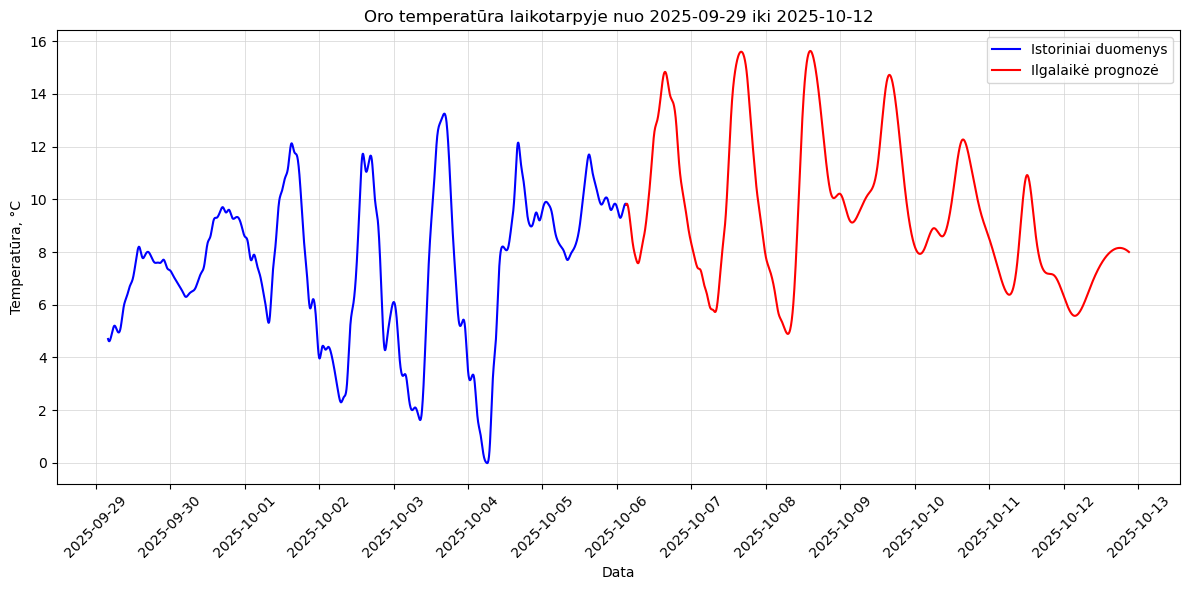

In [15]:
plot_series(
    data_1 = df_obs_last_7_days_int,
    data_2 = df_fcast_with_overlap_int,
    label_1="Istoriniai duomenys",
    label_2="Ilgalaikė prognozė"
)

# Ataskaitos paruosimas

In [18]:
env = Environment(loader=FileSystemLoader('.'))
template = env.get_template("report_template.html")

absolute_path = os.path.join(os.getcwd(), "temp_plot_output.png")
plot_path_url = pathlib.Path(absolute_path).as_uri()

html_out = template.render(
    title = "Kauno meteorologinių rodiklių skaičiavimo ir atvaizdavimo ataskaita",
    df_obs_start = df_obs_start,
    df_obs_end = df_obs_end,
    avg_obs_temp = round(avg_obs_temp, 2),
    avg_obs_hum = round(avg_obs_hum, 2),
    avg_obs_temp_diena = round(avg_obs_temp_diena, 2),
    avg_obs_temp_naktis = round(avg_obs_temp_naktis, 2),
    savaitgaliu_su_lietum_skaicius = savaitgaliu_su_lietum_skaicius,
    plot_path = plot_path_url 
)

try:
    HTML(string=html_out).write_pdf("report.pdf")
    
    print("PDF ataskaita sugeneruota: report.pdf")
except Exception as e:
    print(f"Klaida generuojant PDF: {e}. Patikrinkite, ar įdiegėte 'weasyprint' priklausomybes.")

PDF ataskaita sugeneruota: report.pdf


In [19]:
!python --version

Python 3.10.18
